# Scope
Since the input state is continuous in Cartpole tutorial, a function approximation should be used for predicting the state function (neural network is used), and in this case, the traces of the network parameters should be considered instead of the those of the states [1]. However, in this example, we found that even if we use the method of using the trace of the state, model can be trained to some extent. We will cover that part as well and compare them. <br>
Among the three types of eligibility traces (accumulating, replace, and dutch traces), we will use the accumulating trace for tracing network parameters because it is not theoretically based on the linear function approximation of the value function [2]. And we will use replacing trace when states are traced.

## Highlights
- The result of using the state trace and the parameter trace is compared for the case of non-linear value function approximation.
- The stochastic gradient descent (SGD) method has poor performance in this example, so we novelly convert the semi-gradient method using SGD in [2] 293p to Adam-like method for the case of parameter trace.

In [1]:
from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler
from torch.nn import functional as F
import gym
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import math


Declare hyperparameters for model training.

In [2]:
GAMMA = 0.99
LR = 0.001
ALPHA = 0.001 # learning step of paramter trace
EPSILON_DECAY_RATE = 0.9999
LAMBDA = 0.9
BATCH_SIZE = 40
LOSS_RECORD_TERM = 100
MAX_STEPS = 100000
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'


## 1. SARSA with state trace

In [3]:
class QNetwork(nn.Module):
    def __init__(self):
        super(QNetwork, self).__init__()

        self.fc1 = nn.Linear(obs_size, 32)
        self.fc2 = nn.Linear(32,32)
        self.fc3 = nn.Linear(32,32)
        self.fc4 = nn.Linear(32, act_size)

    def forward(self, s):
        q = F.relu(self.fc1(s))
        q = F.relu(self.fc2(q))
        q = F.relu(self.fc3(q))
        q = self.fc4(q)

        return q

In [4]:
class SARSABasic:
    def __init__(self, q_network):
        self.net = q_network
        self.epsilon = 1
        self.min_epsilon = 0.01
        
    def get_action(self, s):
        s_tensor = torch.from_numpy(s).float().to(DEVICE)
        # epsilon-greedy policy
        if np.random.rand() < self.epsilon:
            a = np.random.randint(act_size)
        else:
            q = self.net(s_tensor)
            a = torch.argmax(q).item()
        return a

    def get_delta(self, s, a, r, s_, a_, d):
        s = torch.tensor(s).reshape(1, obs_size).float().to(DEVICE)
        a = torch.tensor(a).reshape(1, 1).long().to(DEVICE)
        s_ = torch.tensor(s_).reshape(1, obs_size).float().to(DEVICE)
        a_ = torch.tensor(a_).reshape(1, 1).long().to(DEVICE)
        d = torch.tensor(d).reshape(1, 1).float().to(DEVICE)
        q = torch.gather(self.net(s), 1, a)
        q_ = torch.gather(self.net(s_), 1, a_)

        delta = r + GAMMA * q_ * (1 - d) - q
        return delta



In [5]:
class SARSAStateTrace(SARSABasic):
    def __init__(self, q_network):
        super().__init__(q_network)
        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.net.parameters(), LR)
        self.eligibility_trace = {}
        
    def clear_trace(self):
        self.eligibility_trace.clear()
        
    def record_state_trace(self, s, a):
        s = tuple(s) # to hashable
        if (s,a) in self.eligibility_trace.keys():
            self.eligibility_trace[(s,a)] += 1
        else:
            self.eligibility_trace[(s,a)] = 1
    
    def update_trace(self):
        if LAMBDA != 0:
            for key in self.eligibility_trace.keys():
                self.eligibility_trace[key] *= LAMBDA  
        else :
            self.clear_trace()
            
    def update(self, delta):        
        self.epsilon = max(self.min_epsilon, self.epsilon * EPSILON_DECAY_RATE)
        trace = list(self.eligibility_trace.items())
        sampler = BatchSampler(SubsetRandomSampler(trace), BATCH_SIZE, drop_last=False)
        for batch in sampler:
            s_batch = np.empty(shape=(len(batch), obs_size))
            a_batch = np.empty(shape=(len(batch), 1))
            e_batch = np.empty(shape=(len(batch), 1))
            for i, ((s,a), e) in enumerate(batch):
                s_batch[i] = s
                a_batch[i] = a
                e_batch[i] = e
            
            s = torch.tensor(s_batch).float().to(DEVICE)
            a = torch.tensor(a_batch).long().to(DEVICE)
            e = torch.tensor(e_batch).float().to(DEVICE)
            
            q = torch.gather(self.net(s), 1, a)
            # Basic formula : Q(s,a) ← Q(s,a) + alpha*delta*E(s,a)
            loss = self.criterion(q, (q+delta*e).detach())
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

        return loss.detach().cpu().numpy()

### Visualization module

In order to visualize the training, we define a class that draws a loss function and cumulative rewards as training progresses.

In [6]:
class Graph:
    def __init__(self):
        self.max_num_data = 200        
        self.fig, self.ax = plt.subplots(1, 2, figsize=(12, 4))
        self.loss_graph, = self.ax[0].plot(1)
        self.reward_graph, = self.ax[1].plot(1)
        self.ax[0].set_title("Loss")
        self.ax[0].set_xlim(0,1)
        self.ax[0].set_ylim(0,2)
        self.ax[0].set_yscale('log')
        self.ax[0].set_xlabel('step')
        self.ax[0].set_ylabel('loss')
        self.ax[1].set_title("Cumulative reward")
        self.ax[1].set_xlim(0,10)
        self.ax[1].set_ylim(0,2)
        self.ax[1].set_xlabel('episode')
        self.ax[1].set_ylabel('reward')
    
    def update_loss(self, loss_list):
        while len(loss_list) > self.max_num_data:
            loss_list = [data for idx, data in enumerate(loss_list) if idx %2 == 0]
        
        x = [i[0] for i in loss_list]
        y = [i[1] for i in loss_list]        
        self.ax[0].set_xlim(0,x[-1])
        self.ax[0].set_ylim(np.min(y)*0.9,np.max(y)*1.1)
        self.loss_graph.set_xdata(x)
        self.loss_graph.set_ydata(y)        
        self.fig.canvas.draw()
        self.fig.canvas.flush_events()     
        
    def update_reward(self, reward_list):
        while len(reward_list) > self.max_num_data:
            reward_list = [data for idx, data in enumerate(reward_list) if idx %2 == 0]
        
        x = [i[0] for i in reward_list]
        y = [i[1] for i in reward_list]        
        self.ax[1].set_xlim(0,x[-1])
        self.ax[1].set_ylim(np.min(y)*0.9, np.max(y)*1.1)
        self.reward_graph.set_xdata(x)
        self.reward_graph.set_ydata(y)        
        self.fig.canvas.draw()
        self.fig.canvas.flush_events()    

### Training the model

Create an Cartpole environment and instances of our SARSA (state trace) model.

In [7]:
env = gym.make("CartPole-v1")
obs_size = env.observation_space.shape[0]
act_size = env.action_space.n
q_network = QNetwork().to(DEVICE)
agent = SARSAStateTrace(q_network)


<IPython.core.display.Javascript object>


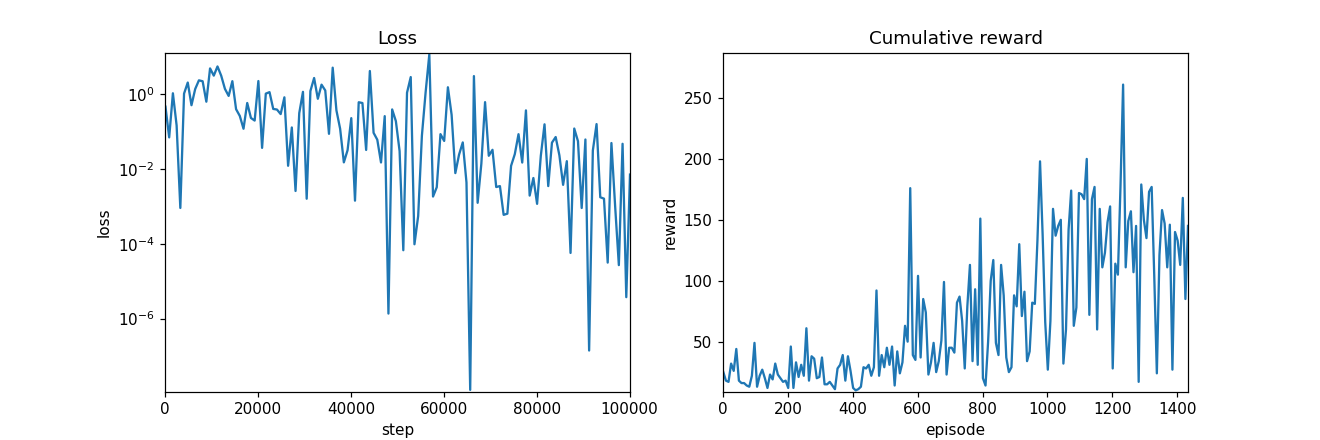

In [8]:
%matplotlib notebook
plt.ion()
graph = Graph()

loss_list = []
reward_list = []
episode = 0
total_step = 0
while total_step < MAX_STEPS:
    episode += 1
    cum_reward = 0
    agent.clear_trace()
    state = env.reset()
    action = agent.get_action(state) 

    while True :
        total_step += 1
        env.render()
        next_state, reward, done, info = env.step(action)
        next_action = agent.get_action(next_state)
        delta = agent.get_delta(state,action,reward,next_state,next_action,done)
        agent.record_state_trace(state, action)

        loss = agent.update(delta)
        agent.update_trace()
        action = next_action
        state = next_state
        cum_reward += reward    
        
        # record loss
        if total_step % LOSS_RECORD_TERM == 0: 
            loss_list.append([total_step,loss])
            graph.update_loss(loss_list)
            
        # terminated            
        if done:
            reward_list.append([episode, cum_reward])
            graph.update_reward(reward_list)
            break

env.close()

## 2. SARSA with network parameter trace

Second, we test the SARSA algorithm that uses the trace of the neural network parameters.

### Theoretical background of the parameter update rule

This algorithms starts from p.293 in [2]. This semi-gradient algorithm updates the network paramter w as follows. <br>
<pre>  w ← w + αδe ,where δ is (R+γQ'-Q) and e is ∂Q/∂w + γλ(past gradient ...) </pre>
From the view point of ∂Q(t)/∂w(t), this formula can be rewritten as a stepwise update like the following equation:   
<pre>  w ← w + α[R(t+1)+γQ(t+1)-Q(t)][∂Q(t)/∂w(t)] + αγλ[R(t+2)+γQ(t+2)-Q(t+1)][∂Q(t)/∂w(t)] + ...  </pre>
If we consider it as offline, it is equivalent to stochastic gradient decent update formula with learning rate α/2 when we set the loss function as (Target-Q)^2, where Target = λ-return. It can be proved by the equivalence of the forward view and the backward view [3] after combining the update equation with the term [∂Q(t)/∂w(t)].<br>

However, the cartpole example with a simple SGD method cannot be trained sufficiently (You can check it by changing the optimizer in the SARSA project). <br> Therefore, we update the parameters using the Adam optimizer formula, focusing on the fact that the gradient for this λ-return loss function is -δe. In fact, this algorithm is updated online and Adam applies other parameters other than gradient, so the update rule is not completely identical to the original one.

In [9]:
class SARSAParamTrace(SARSABasic):
    def __init__(self, q_network):
        super().__init__(q_network)        
        self.init_eligibility_trace()
        self.init_adam_parameters()
        
    def init_eligibility_trace(self):
        self.eligibility_trace = {}        
        for name, param in self.net.named_parameters():
            self.eligibility_trace[name] = torch.zeros(size=param.shape).to(DEVICE)
            
    def init_adam_parameters(self):
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.m = {}
        self.v = {}
        for name, param in self.net.named_parameters():
            self.m[name] = torch.zeros(size=param.shape).to(DEVICE)        
            self.v[name] = torch.zeros(size=param.shape).to(DEVICE)   
    
    def update_trace(self, s, a):
        s_tensor = torch.from_numpy(s).reshape(1,obs_size).float().to(DEVICE)
        a_tensor = torch.tensor(a).reshape(1,1).long().to(DEVICE)
        q = torch.gather(self.net(s_tensor), 1, a_tensor) 
        self.net.zero_grad()
        q.backward()
        for name, param in self.net.named_parameters():
            self.eligibility_trace[name] *= GAMMA*LAMBDA
            self.eligibility_trace[name] += param.grad

    def clear_trace(self):
        self.init_eligibility_trace()
            
    def update_sgd(self, delta):
        self.epsilon = max(self.min_epsilon, self.epsilon * EPSILON_DECAY_RATE)        
        apparent_loss = 0
        with torch.no_grad():
            for name, param in self.net.named_parameters():
                param += ALPHA * delta.item() * self.eligibility_trace[name]
                apparent_loss += delta.item()**2    
            if apparent_loss > 1e8:
                raise ValueError("Exploded")
        return apparent_loss
    
    def update_adam(self, delta, t):
        # It follows Adam source code in PyTorch (torch.optim.Adam).
        self.epsilon = max(self.min_epsilon, self.epsilon * EPSILON_DECAY_RATE)
        apparent_loss = 0
        with torch.no_grad():
            for name, param in self.net.named_parameters():
                grad = - delta.item() * self.eligibility_trace[name]                
                exp_avg, exp_avg_sq = self.m[name], self.v[name]

                bias_correction1 = 1 - self.beta1 ** t
                bias_correction2 = 1 - self.beta2 ** t                
                exp_avg.mul_(self.beta1).add_(1 - self.beta1, grad)
                exp_avg_sq.mul_(self.beta2).addcmul_(1 - self.beta2, grad, grad)
                denom = (exp_avg_sq.sqrt() / math.sqrt(bias_correction2)).add_(1e-8)
                step_size = ALPHA / bias_correction1
                param.addcdiv_(-step_size, exp_avg, denom)            
                apparent_loss += delta.item()**2

        return apparent_loss         
        


### Training the model

Check the results with our SARSA (network parameter trace) model.

In [10]:
env = gym.make("CartPole-v1")
obs_size = env.observation_space.shape[0]
act_size = env.action_space.n
q_network = QNetwork().to(DEVICE)
agent = SARSAParamTrace(q_network)

<IPython.core.display.Javascript object>


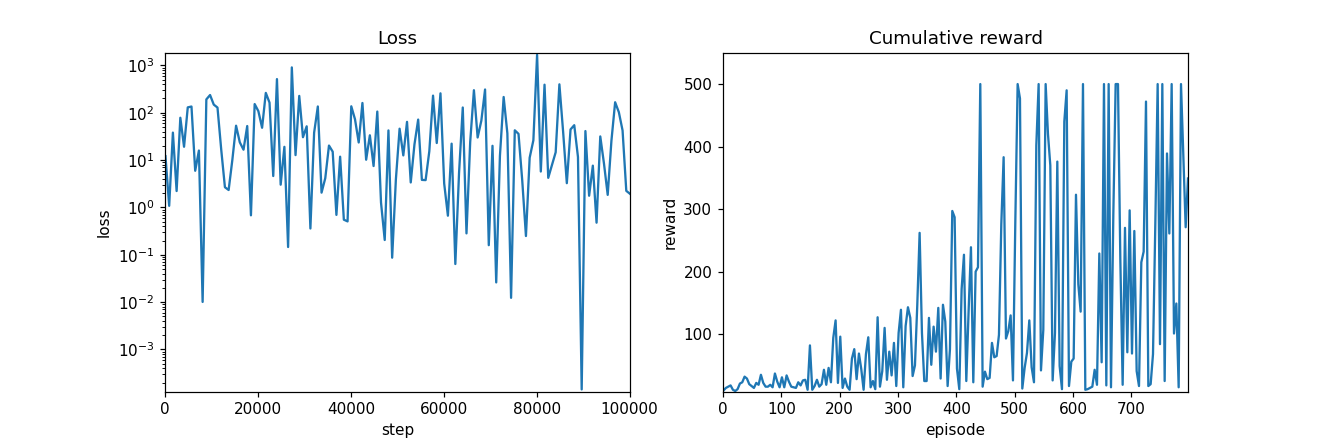

/opt/conda/conda-bld/pytorch_1591914880026/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


In [11]:
%matplotlib notebook
plt.ion()
graph = Graph()

loss_list = []
reward_list = []
episode = 0
total_step = 0
while total_step < MAX_STEPS:
    episode += 1
    cum_reward = 0
    agent.clear_trace()
    state = env.reset()
    action = agent.get_action(state) 

    while True :
        total_step += 1
        env.render()
        next_state, reward, done, info = env.step(action)
        next_action = agent.get_action(next_state)
        delta = agent.get_delta(state,action,reward,next_state,next_action,done)
        agent.update_trace(state, action)
        loss = agent.update_adam(delta, total_step)

        action = next_action
        state = next_state
        cum_reward += reward    
        
        # record loss
        if total_step % LOSS_RECORD_TERM == 0: 
            loss_list.append([total_step,loss])
            graph.update_loss(loss_list)
            
        # terminated            
        if done:
            reward_list.append([episode, cum_reward])
            graph.update_reward(reward_list)
            break

env.close()

Since this example uses the nonlinear function approximation in the continuous state space, the case where parameter trace is used as expected shows more stable performance. Alpha and Lambda are not optimized yet, and you can get different results by converting them.

## References
[1] Sutton, R. S., & Barto, A. G. (1998). Introduction to reinforcement learning (Vol. 135). Cambridge: MIT press. <br>
[2] Sutton, R. S., & Barto, A. G. (2018). Reinforcement learning: An introduction. MIT press. <br>
[3] http://incompleteideas.net/book/first/ebook/node76.html <br>
